### Análisis y Procesamiento de Señales - 2do Cuatrimestre 2025
# **Tarea Semanal 8**: *Filtrado digital lineal de ECG*
#### Mora Taranilla y Victoria Jazmín Salgado

## **Resumen**
Esta tarea semanal se enfoca en el diseño y aplicación de filtros digitales. Se definió una plantilla de especificaciones basada en el ancho de banda estimado de una señal de electrocardiograma (ECG) y posteriormente se llevó a cabo el filtrado de dicha señal, implementando filtros de tipo IIR y FIR, para luego evaluar su desempeño en función de los requerimientos espectrales y temporales determinados.

## **Introducción Teórica**

El objetivo de este trabajo fue mitigar la contaminación presente en una señal de ECG registrada durante una prueba de esfuerzo. 
Dicha contaminación proviene principalmente de fuentes como:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia)
- Ruido muscular (Alta frecuencia)
- Movimiento de Línea de base, inducido en parte por la respiración (Baja frecuencia).

Para poder estudiar la señal sin estos componentes, se utilizarán filtros digitales lineales de diferente naturaleza, que constituyen sistemas LTI (*Linear Time Invariant*).

Dentro de este tipo de filtros, se pueden encontrar aquellos que tienen una respuesta al impulso finita (FIR) o infinita (IIR), lo que les confiere características distintivas. A continuación se exponen sus principales diferencias.

### Filtros FIR
Un filtro FIR no cuenta con recursividad, es decir, no utiliza valores pasados de la salida para calcular la actual. Los coeficientes de realimentación $a_k$ del sistema son cero excepto en el caso de $a_0$, donde el valor es igual a 1. De esta forma, la ecuación en diferencias que representa al sistema es:

$$
y[n] = \sum_{k=0}^{N-1} b_k \cdot x[n-k]
$$

Siendo N la longitud del vector de coeficientes $b_k$. La sumatoria comienza en cero ya que se trabaja sobre señales causales.

Estos filtros se clasifican en cuatro tipos, que dependen de la simetría de la respuesta al impulso y la longitud de la misma (que puede ser par o impar). De esta forma se definen:

- Tipo I: Simetría par y longitud impar.
- Tipo II: Simetría par y longitud par.
- Tipo III: Simetría impar y longitud impar.
- Tipo IV: Simetría impar y longitud par.

Los filtros FIR cuentan con muchas ventajas, entre ellas que los mismos son siempre estables, ya que los polos se encuentran únicamente en el origen, y que pueden diseñarse con fase lineal, lo que asegura un retardo de grupo constante para todas las frecuencias. Esto es de especial importancia en señales como ECG, en las que es necesario conservar la forma de onda para su análisis clínico. Para llevar a cabo un filtro FIR hay tres métodos principales: método de ventanas, método de cuadrados mínimos y método de Parks-McClellan. 

### Filtros IIR

A diferencia de los FIR, los filtros IIR poseen recursividad (términos $y[n-k]$, que toman valores pasados de la salida para calcular la actual). Para un filtro IIR la ecuación en diferencias causal general (normalizada con $a_0 = 1$) es

$$
y[n] = \sum_{k=0}^{N} b_k\,x[n-k] \;-\; \sum_{k=1}^{M} a_k\,y[n-k] , \qquad n\in\mathbb{Z}
$$

La ventaja de este tipo de filtros, frente a los FIR descritos anteriormente, es que pueden cumplir con las especificaciones exigidas con un orden menor que un filtro FIR equivalente, lo que resulta en menor costo computacional y mayor velocidad de procesamiento. Por otro lado, la desventaja que presentan es la introducción de una distorsión de fase no lineal.

## **Desarrollo**
En primer lugar, se llevó a cabo el diseño de la plantilla para el filtrado digital de la señal de ECG.

Los parámetros de la plantilla se definieron en base a una estimación del ancho de banda de la señal, calculada previamente en la Tarea Semanal 5. En la misma, a partir de la estimación del espectro de potencias (PSD) mediante el método de Blackman-Tukey, se determinó que la señal de ECG concentra su energía útil en un ancho de banda aproximado de 30,67Hz. 

Se establece entonces una máscara para un filtro pasa-banda con las siguientes características:
- Banda de paso (*wp*): Se define con un margen de holgura respecto al ancho de banda estimado, estableciendo el paso entre 1Hz y 35Hz. Permite conservar la información eliminando la continua y el ruido de alta frecuencia.
- Banda de Stop (*ws*): Se busca atenuar las frecuencias por debajo de 0.1Hz y por encima de 40Hz (eliminando ruido de alta frecuencia, incluido en éste el de línea y muscular)
- Las bandas de transición quedan definidas implícitamente en los intervalos [0.1, 1]Hz y [35,40] Hz
- Se permite un *ripple* máximo de 1dB en la banda de paso y se exige una atenuación mínima (*$\alpha_min$*) de 40dB en la banda de stop.
- La frecuencia de muestreo se fija en 1000Hz. Ésta supera ampliamente el requerimiento del Teorema de Nyquist ($f_s > 2 \cdot Bw \approx 80 Hz$), sin embargo de esta manera se asegura una resolución temporal adecuada para poder observar  los complejos rápidos que constituyen a la señal (como el QRS).

Estos requerimientos permitirán que no se pierda información relevante, logrando que, tras el filtrado, se conserve la morfología del latido promedio, facilitando la identificación de sus complejos y estableciendo el nivel isoeléctrico en cero. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from plantilla_TS8 import plantilla

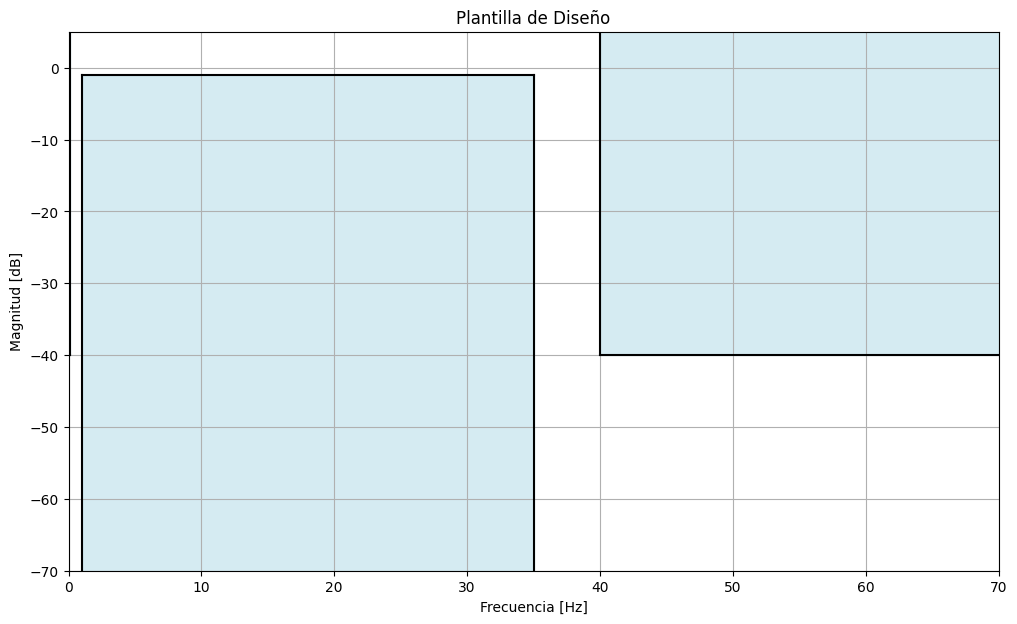

In [3]:
fs = 1000 #Hz
ripple = 1 # dB
atenuacion = 40 # dB

wp = [1, 35] #Hz
ws = [0.1, 40] #Hz

plt.figure(figsize=(12,7))
plt.title('Plantilla de Diseño')
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.xlim([0,70])
plt.ylim([-70,5])
plt.show()

Una vez que se contó con la plantilla de diseño de los filtros, se prodeció al filtrado de la señal implementando tanto filtros IIR como FIR.

**FILTROS IIR:**
Se utilizaron los siguientes filtros IIR:
- Butterworth (planicidad máxima)
- Chebyschev (I y II)
- Cauer (Elliptic)

Se comienza por importar la señal de ECG a filtrar, graficándo la secuencia de muestras para obtener una visión general de la misma. 
Esta inspección visual permite identificar el efecto del movimiento de línea de base, que se observa como una tendencia de baja frecuencia sobre la cual se superpone la señal de interés, dificultando la determinación del nivel isoeléctrico. 

In [40]:
fs_ecg = 1000 # Hz

sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].squeeze()
N = len(ecg_one_lead)

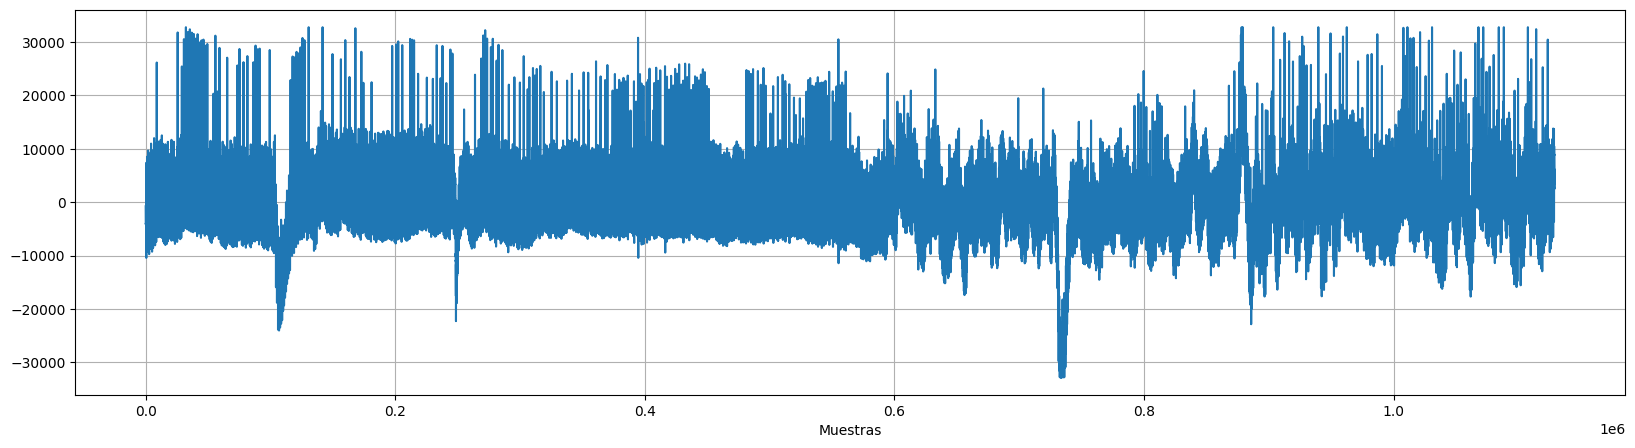

In [41]:
plt.figure(figsize=(20,5))
plt.plot(ecg_one_lead)
plt.xlabel('Muestras')
plt.grid(True)

Luego se diseñan los filtros IIR, utilizando la funcion de scipy *iirdesign*. Esta herramienta utiliza los parámetros definidos en la plantilla de diseño, y devuelve las secciones bicuadráticas necesarias para la implementación del filtro. Cabe destacar que se elige utilizar SOS (Secciones Bicuadráticas) para evitar problemas de precisión numérica que pueden presentarse en filtros de orden alto, descomponiéndolo en una cascada de filtros de segundo orden. 

In [6]:
f_aprox = 'butter'
mi_sos_butter = signal.iirdesign(wp=wp, ws=ws, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cheby1'
mi_sos_cheby1 = signal.iirdesign(wp=wp, ws=ws, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cheby2'
mi_sos_cheby2 = signal.iirdesign(wp=wp, ws=ws, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cauer'
mi_sos_cauer = signal.iirdesign(wp=wp, ws=ws, gpass=ripple, gstop=atenuacion, analog=False, ftype=f_aprox, output='sos', fs=fs)

Se continúa por aplicar los filtros diseñados sobre la señal ECG. 
Dado que los filtros IIR introducen distorsión de fase no lineal, se optó por implementar un filtrado bidireccional utilizando la función *sosfiltfilt*. Esta técnica compensa los desfases introducidos, resultando en un sistema con respuesta de fase nula. Esto es de suma importancia en este tipo de señales, ya que de esta manera no habrá retardo de grupo. Así, será posible preservar la forma y el alineamiento de las ondas. 

In [7]:
ecg_filt_butter = signal.sosfiltfilt(mi_sos_butter, ecg_one_lead)
ecg_filt_cauer = signal.sosfiltfilt(mi_sos_cauer, ecg_one_lead)
ecg_filt_cheby1 = signal.sosfiltfilt(mi_sos_cheby1, ecg_one_lead)
ecg_filt_cheby2 = signal.sosfiltfilt(mi_sos_cheby2, ecg_one_lead)

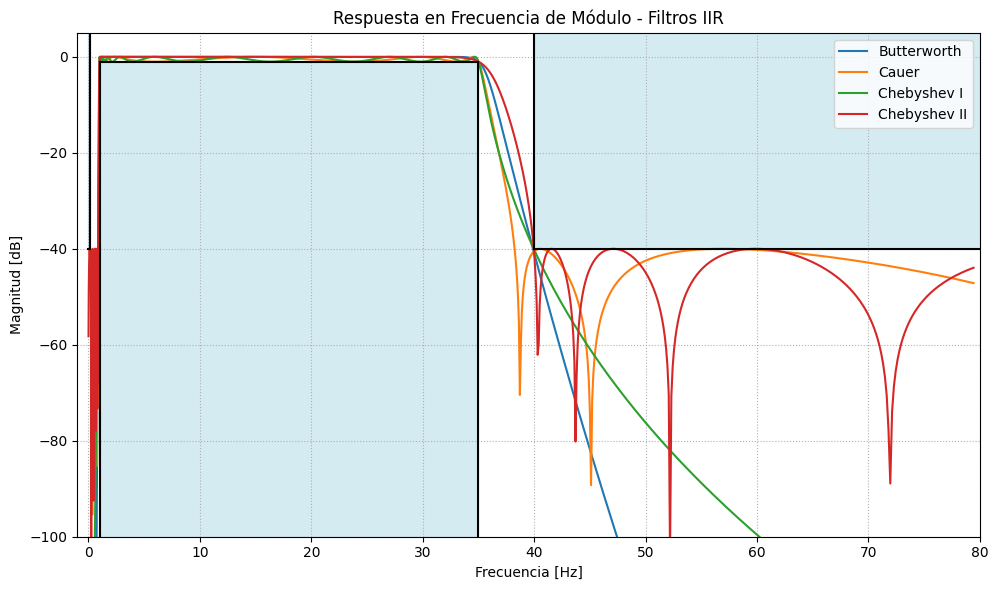

In [38]:
# Frecuencia de muestreo
fs = 1000  

# Calculamos respuesta en frecuencia para cada filtro
w, h_butter = signal.sosfreqz(mi_sos_butter, worN=np.logspace(-2, 1.9, 4000), fs=fs) #agrego puntos de muestreo donde me interesa
_, h_cauer  = signal.sosfreqz(mi_sos_cauer, worN=np.logspace(-2, 1.9, 4000), fs=fs)
_, h_cheby1 = signal.sosfreqz(mi_sos_cheby1, worN=np.logspace(-2, 1.9, 4000), fs=fs)
_, h_cheby2 = signal.sosfreqz(mi_sos_cheby2, worN=np.logspace(-2, 1.9, 4000), fs=fs)

plt.figure(figsize=(10,6))
plt.plot(w, 20*np.log10(np.maximum(abs(h_butter), 1e-8)), label='Butterworth')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cauer), 1e-8)), label='Cauer')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby1), 1e-8)), label='Chebyshev I')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby2), 1e-8)), label='Chebyshev II')

plt.title('Respuesta en Frecuencia de Módulo - Filtros IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.xlim(-1,80)
plt.ylim(-100, 5)
plt.show()

Observando el gráfico del módulo de la respuesta en frecuencia de los filtros IIR implementados, se verifica que todos cumplen con los requerimientos especificados anteriormente. 

La magnitud de la respuesta se mantiene dentro de los límites impuestos por la plantilla de diseño, respetando las tolerancias establecidas: el ripple en la banda de paso no excede el umbral de 1 dB y se garantiza la atenuación mínima requerida en las bandas de rechazo (40 dB).

<function matplotlib.pyplot.show(close=None, block=None)>

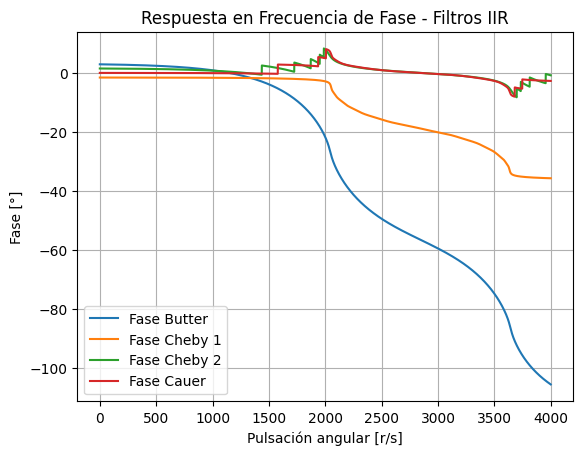

In [39]:
phase_butter = np.unwrap(np.angle(h_butter))
phase_cheby1 = np.unwrap(np.angle(h_cheby1))
phase_cheby2 = np.unwrap(np.angle(h_cheby2))
phase_cauer = np.unwrap(np.angle(h_cauer))
plt.figure()
plt.plot(phase_butter, label='Fase Butter')
plt.plot(phase_cheby1, label='Fase Cheby 1')
plt.plot(phase_cheby2, label='Fase Cheby 2')
plt.plot(phase_cauer, label='Fase Cauer')
plt.grid(True)
plt.title('Respuesta en Frecuencia de Fase - Filtros IIR')
plt.xlabel('Pulsación angular [r/s]')
plt.ylabel('Fase [°]')
plt.legend()
plt.show

Por otro lado, se verifica en el gráfico de la respuesta de fase que ésta no es lineal para ningún filtro, lo que se corresponde con lo esperado para filtros de Tipo IIR.

A continuación se hace un detalle de las zonas críticas del diseño para la respuesta de módulo: 

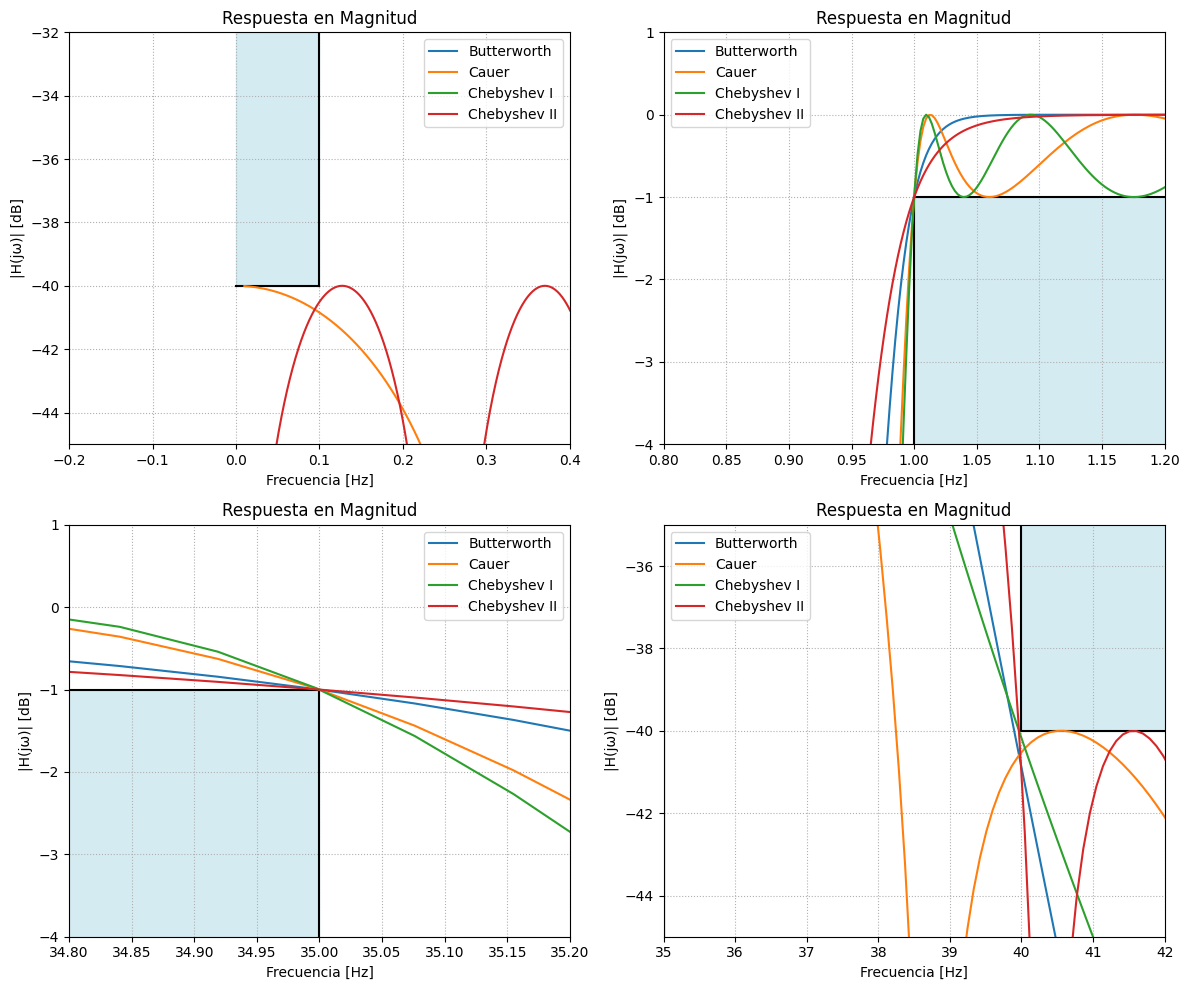

In [30]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w, 20*np.log10(np.maximum(abs(h_butter), 1e-8)), label='Butterworth')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cauer), 1e-8)), label='Cauer')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby1), 1e-8)), label='Chebyshev I')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby2), 1e-8)), label='Chebyshev II')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-45,-32)
plt.xlim(-0.2,0.4)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,2)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w, 20*np.log10(np.maximum(abs(h_butter), 1e-8)), label='Butterworth')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cauer), 1e-8)), label='Cauer')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby1), 1e-8)), label='Chebyshev I')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby2), 1e-8)), label='Chebyshev II')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-4,1)
plt.xlim(0.8,1.2)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,3)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w, 20*np.log10(np.maximum(abs(h_butter), 1e-8)), label='Butterworth')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cauer), 1e-8)), label='Cauer')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby1), 1e-8)), label='Chebyshev I')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby2), 1e-8)), label='Chebyshev II')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-4,1)
plt.xlim(34.8,35.2)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,4)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w, 20*np.log10(np.maximum(abs(h_butter), 1e-8)), label='Butterworth')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cauer), 1e-8)), label='Cauer')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby1), 1e-8)), label='Chebyshev I')
plt.plot(w, 20*np.log10(np.maximum(abs(h_cheby2), 1e-8)), label='Chebyshev II')

plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-45,-35)
plt.xlim(35,42)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.tight_layout()
plt.show()

En base a los gráficos presentados, se corrobora el cumplimiento de los requerimientos de diseño por parte de los filtros IIR.

Se continúa por evaluar el filtrado en el dominio del tiempo, graficando de manera de poder observar la morfología de la señal tras pasar por los sistemas. 

Para comenzar, se graficarán las primeras 200000 muestras tanto de la señal original como de la filtrada, para poder ver el comportamiento de manera más general. 

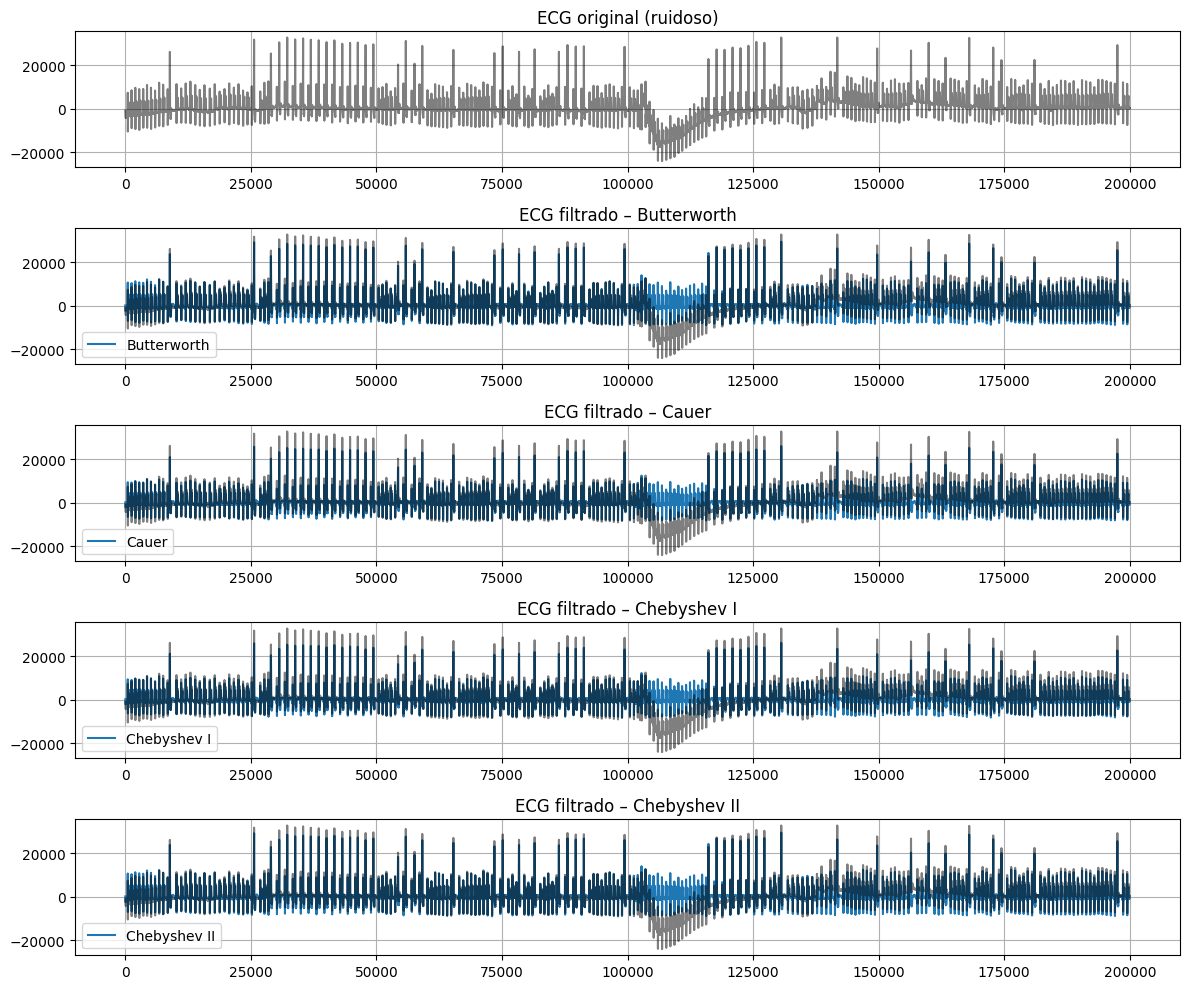

In [9]:
#panorama general mas muestras

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[:200000], label='Butterworth')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[:200000], label='Cauer')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[:200000], label='Chebyshev I')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[:200000], label='Chebyshev II')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Como primer indicio cualitativo del correcto desempeño del filtro, se observa que el proceso de filtrado eliminó de manera eficaz el movimiento de línea de base en la región graficada.

A diferencia de la señal original, que presentaba una fuerte tendencia de baja frecuencia, la señal filtrada se encuentra ahora estabilizada y centrada alrededor del cero (nivel isoeléctrico nulo). 

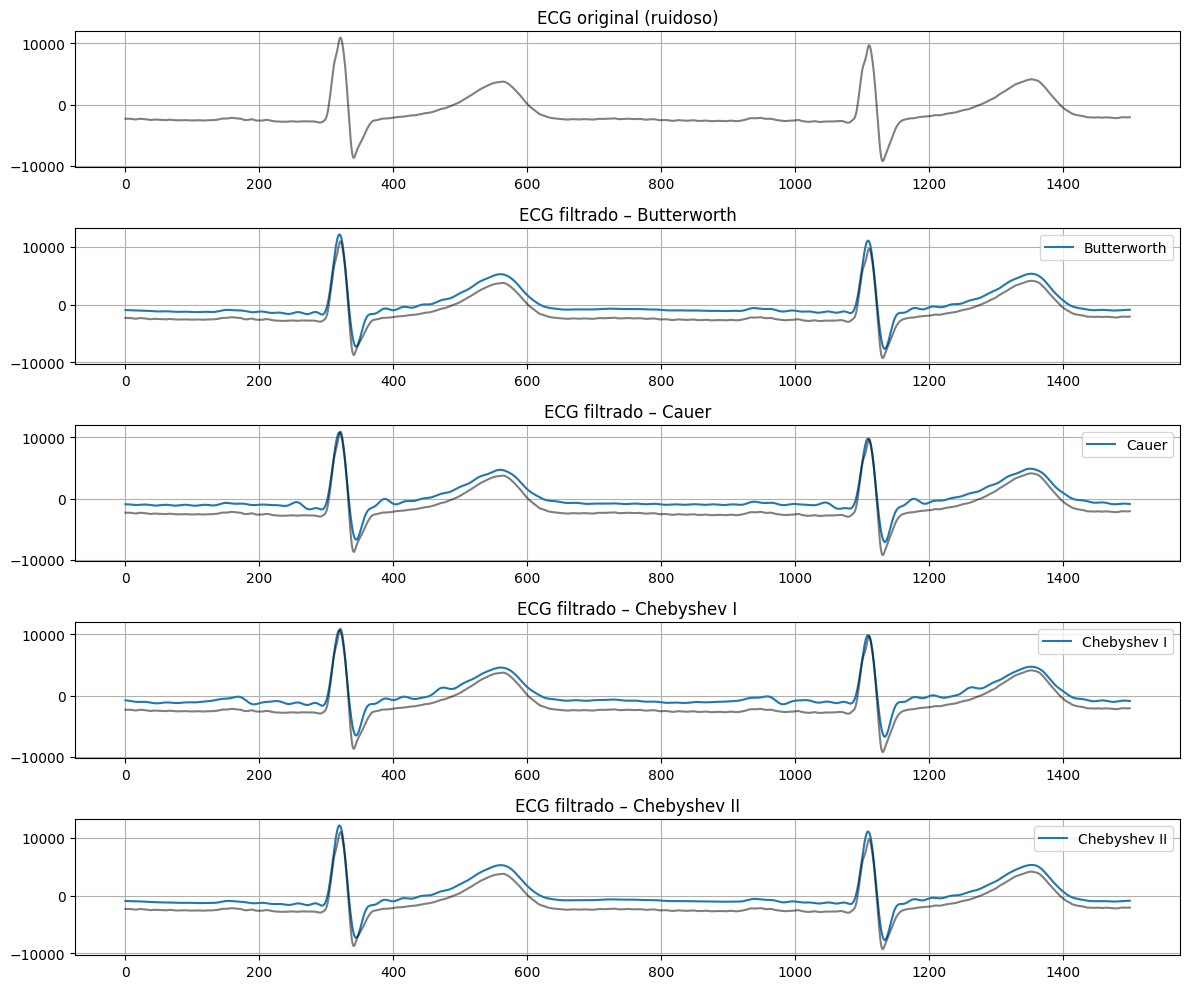

In [10]:
#Región de interés 1 [4000:5500] - zona no ruidosa

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[4000:5500], label='Butterworth')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[4000:5500], label='Cauer')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[4000:5500], label='Chebyshev I')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[4000:5500], label='Chebyshev II')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Por otro lado, para poder hacer otra evaluación cualitativa, se grafican dos latidos consecutivos presentes en zonas de la señal consideradas no ruidosas. El objetivo es poder ver con mayor claridad la señal de salida de los diferentes filtros y corroborar su inocuidad en regiones de estas características.

Se observa que la morfología de la señal y los complejos que la componen fue conservada, pero se introducen oscilaciones en el dominio del tiempo que no son propias de la señal; ésto se relaciona con la respuesta del filtro frente a un estímulo similar a una respuesta al impulso dada por el complejo QRS. Éste fenómeno se denomina *Ringing*.

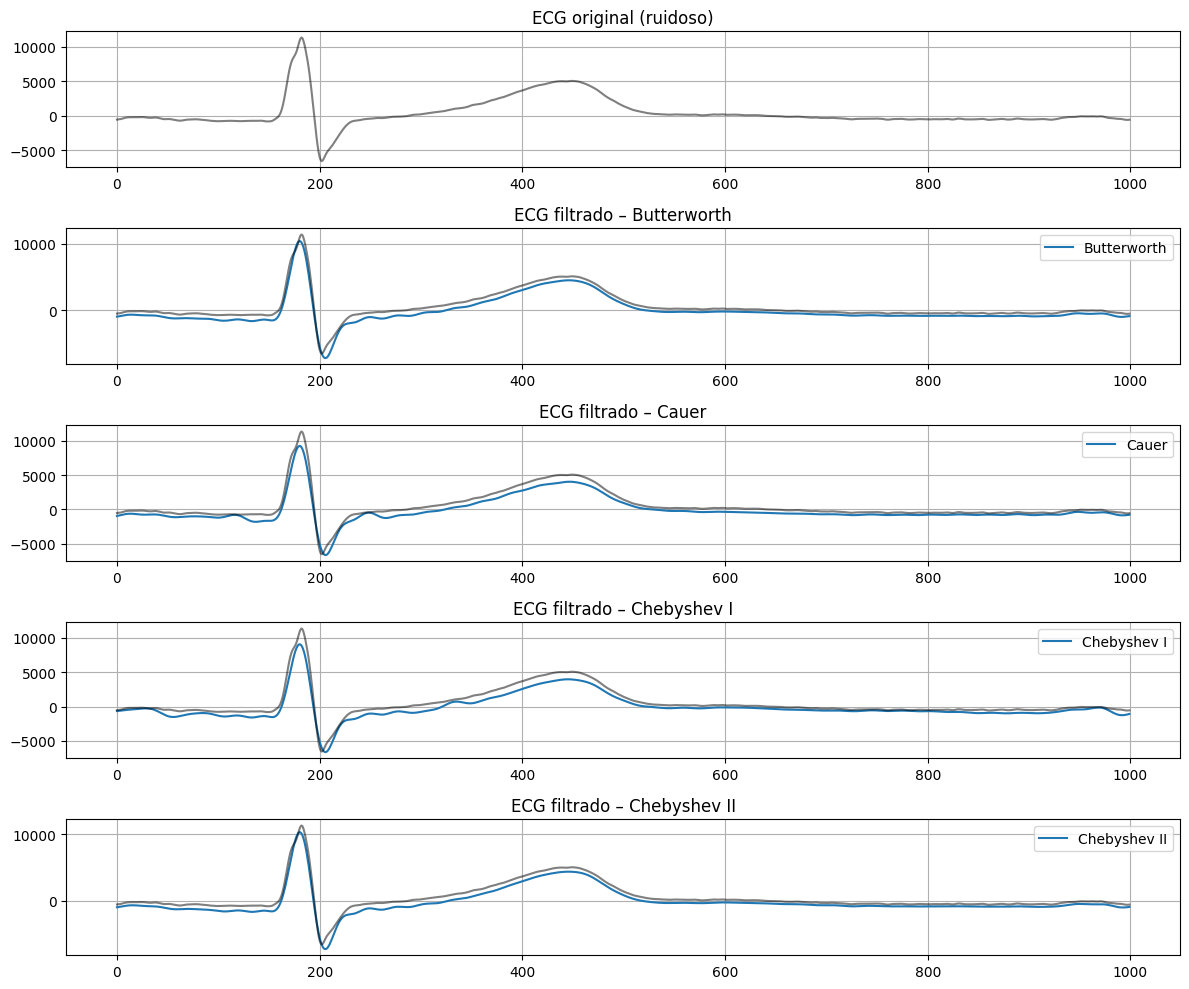

In [11]:
#Región de interés 2 [10e3, 11e3] - zona no ruidosa

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[10000 : 11000], label='Butterworth')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[10000 : 11000], label='Cauer')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[10000 : 11000], label='Chebyshev I')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[10000 : 11000], label='Chebyshev II')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Por último, se seleccionaron tres regiones de interés correspondientes a segmentos donde la señal presenta una degradación significativa, producto de las fuentes de contaminación caracterizadas en la introducción. Se grafica la señal original frente a la filtrada en el dominio temporal:

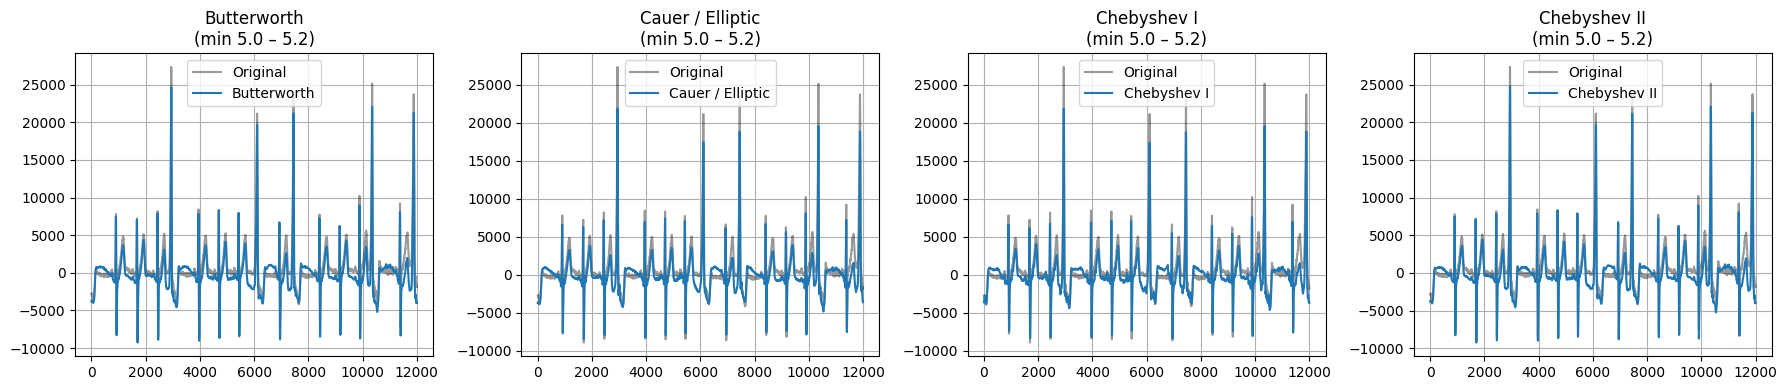

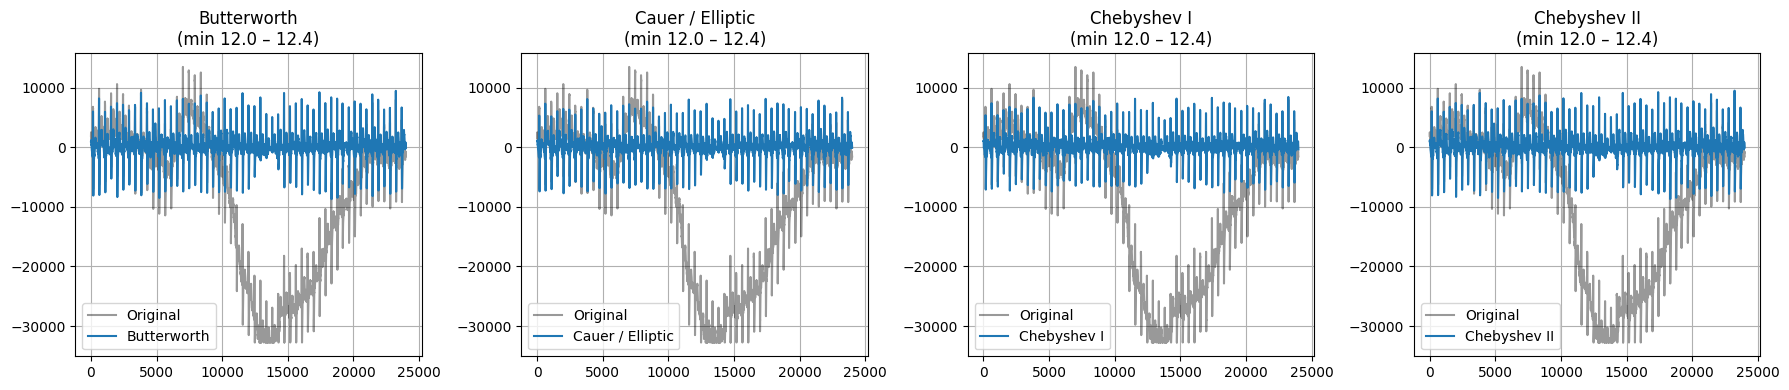

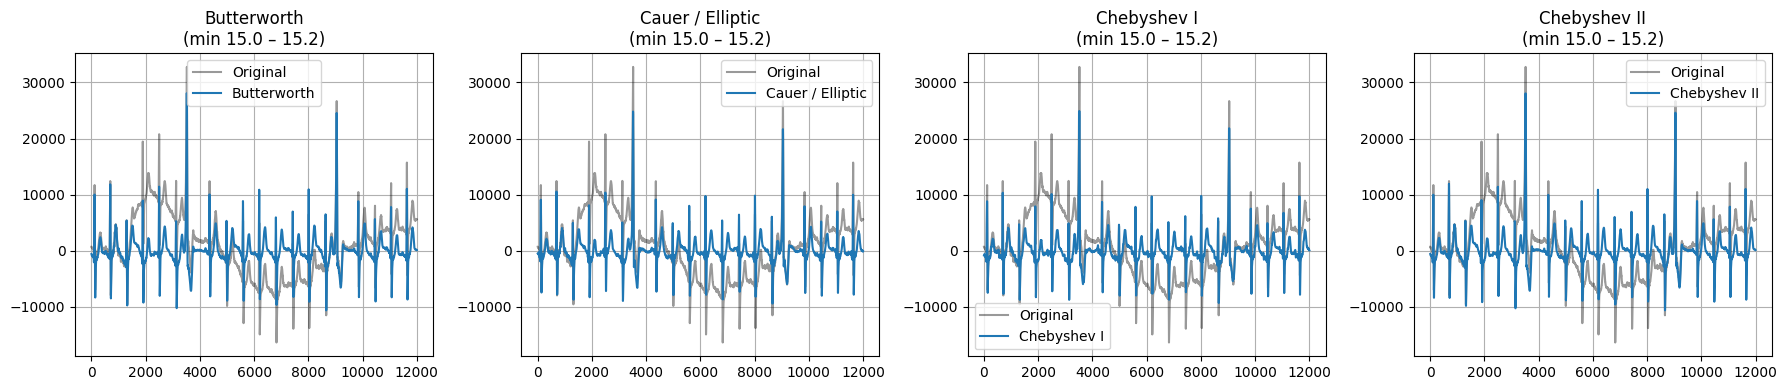

In [12]:
# Regiones de interés RUIDOSAS en minutos → muestras
regs_interes = (
    np.array([5, 5.2])  * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

regs_interes = [(int(a), int(b)) for a, b in regs_interes]

filtros = [
    (ecg_filt_butter, "Butterworth"),
    (ecg_filt_cauer,  "Cauer / Elliptic"),
    (ecg_filt_cheby1, "Chebyshev I"),
    (ecg_filt_cheby2, "Chebyshev II"),
]

for (i0, i1) in regs_interes:
    
    plt.figure(figsize=(18,4))

    for j, (filt, nombre) in enumerate(filtros, start=1):

        plt.subplot(1, 4, j)
        plt.plot(ecg_one_lead[i0:i1], color='k', alpha=0.4, label="Original")
        plt.plot(filt[i0:i1], label=nombre)
        plt.title(f"{nombre}\n(min {i0/(fs*60):.1f} – {i1/(fs*60):.1f})")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

A partir del análisis visual de los resultados, es posible concluir que los filtros IIR implementados logran mitigar eficazmente el efecto del movimiento de la línea de base, que constituía la interferencia más notoria en la señal original.

Asimismo, se verifica que la morfología de la señal estudiada se mantiene preservada. Si bien se observa la introducción de leves oscilaciones transitorias (ringing) en los complejos rápidos (QRS), el desempeño general se considera satisfactorio, ya que mejora la legibilidad de la señal para su posterior análisis clínico.

**FILTROS FIR:**
Los métodos de implementación digital para filtros de respuesta al impulso finita mencionados anteriormente se rigen por la siguiente metodología:

- Método de Ventanas:

Este es un método directo, que garantiza el funcionamiento al diseñarlo, pero no es el óptimo. A la respuesta deseada del filtro (un "brickwall") se le aplica la antitransformada de Fourier, obteniendo la respuesta al impulso con soporte infinito. La misma se ventanea para lograr una aproximación sin soporte infinito. La respuesta al impulso ventaneada determina los coeficientes del filtro. 

- Método de Cuadrados Mínimos (Least Squares):

Es un método directo al igual que el método por ventanas y tiene asegurada la convergencia. El mismo tiene como objetivo minimizar el error cuadrático medio que hay entre la respuesta deseada y la respuesta en frecuencia del filtro, es decir:

$$
|E(\Omega)|^2 = \sum_{\Omega\in F} |D(\Omega) - H_R(\Omega)|^2
$$

Siendo $D(\Omega)$ la respuesta deseada y $H_R(\Omega)$ la respuesta en frecuencia del filtro.

- Método de Parks-McClellan (Remez):

A diferencia de los métodos mencionados anteriormente, este último si es iterativo, es decir que, se lleva a cabo mediante un algoritmo que se repita hasta obtener un resultado que cumpla las condiciones propuestas. Al ser iterativo, no se asegura la convergencia, lo que presenta una alta desventaja frente a los métodos anteriores. Este método busca minimizar el error entre la respuesta deseada y la respuesta en frecuencia, enfocado en las bandas de interés. Esto permite que el filtro tenga un mejor rendimiento donde se defina.


A continuación se presenta el diseño mediante funciones de *scipy.signal*. Para cumplir con la plantilla, se definieron nuevas frecuencias de paso y de rechazo, para que las mismas sean simétricas y no comprometan el diseño de los filtros. En esa redefinición, se respetó la transición más abrupta y se modificó la que contaba con más libertad. Se ordenaron las frecuencias, de cero a Nyquist y se definieron las respuestas deseadas para cada una de las frecuencias. 

Para el diseño del método de ventanas, se utilizó la función *firwin2*. La ventana elegida en este caso fue la rectangular, debido a su lóbulo principal angosto frente a las otras ventanas, ya que se requiere que la misma permita transiciones abruptas. Al definir una cantidad de numtaps impar, se logra que el filtro tenga grado par. Al no especificar la simetría, la función realiza un filtro con coeficientes simétricos. Es por ello que, en este caso, se obtuvo un filtro tipo I, lo que resulta en un retardo constante entero. Una vez obtenidos los coeficientes, se calculó la respuesta en frecuencia mediante la función *freqz*.

Se llevó a cabo el mismo procedimiento para los otros métodos.

In [13]:
# Diseño de Filtros FIR
wp_FIR = [1, 35] #comienzo y fin banda de paso
ws_FIR = [0.1, 35.9] #comienzo y fin de banda de stop
frecuencias = np.sort(np.concatenate((wp_FIR,ws_FIR,[0,fs/2]))) #Ordeno las frecuencias
deseado = [0,0,1,1,0,0] #Respuesta deseada para cada frecuencia.

########## METODO VENTANA ##########
# Parámtros
cant_coef_win = 11001 #Elijo impar para que el retardo sea entero
retardo_win = (cant_coef_win - 1)//2
window = 'boxcar' # Rectangular para permitir una transición rapida (lóbulo principal angosto)

fir_win= signal.firwin2(numtaps = cant_coef_win, freq = frecuencias, gain = deseado, nfreqs=int((np.ceil(np.sqrt(cant_coef_win))*4)**2)-1, fs = fs, window = window)
#Devuelve los coeficientes b del filtro.

# Cálculo de las frecuencias y rta en frecuencia del filtro.
w_win, h_win = signal.freqz(b = fir_win, worN=np.logspace(-2, 2, 1000), fs=fs) #por defecto a=1, no recursivo
phase_win = np.unwrap(np.angle(h_win))

########### METODO CUADRADOS MINIMOS ##########
cant_coef_ls = 3251
retardo_ls = (cant_coef_ls - 1)//2

fir_ls = signal.firls(numtaps=cant_coef_ls,bands=frecuencias, desired=deseado, fs=fs)
#Devuelve los coeficientes b del filtro.

#Cálculo de las frecuencias y rta en frecuencia del filtro.
w_ls, h_ls = signal.freqz(b = fir_ls, worN=np.logspace(-2, 1.9, 1000), fs=fs) #por defecto a=1, no recursivo
phase_ls = np.unwrap(np.angle(h_ls))

########### METODO PARKS McCLELLAN - REMEZ ##########
cant_coef_remez = 3251
retardo_remez = (cant_coef_remez - 1)//2
deseado_remez = [0,1,0]
peso_remez = [1,1.5,1]

fir_remez = signal.remez(numtaps=cant_coef_remez, bands=frecuencias, desired=deseado_remez, weight=peso_remez, fs=fs)

w_remez, h_remez = signal.freqz(b = fir_remez, worN=np.logspace(-2, 1.9, 1000), fs=fs) #por defecto a=1, no recursivo
phase_remez = np.unwrap(np.angle(h_remez))

A continuación se estudia el comportamiento de los filtros y si cumplen con la plantilla de diseño.

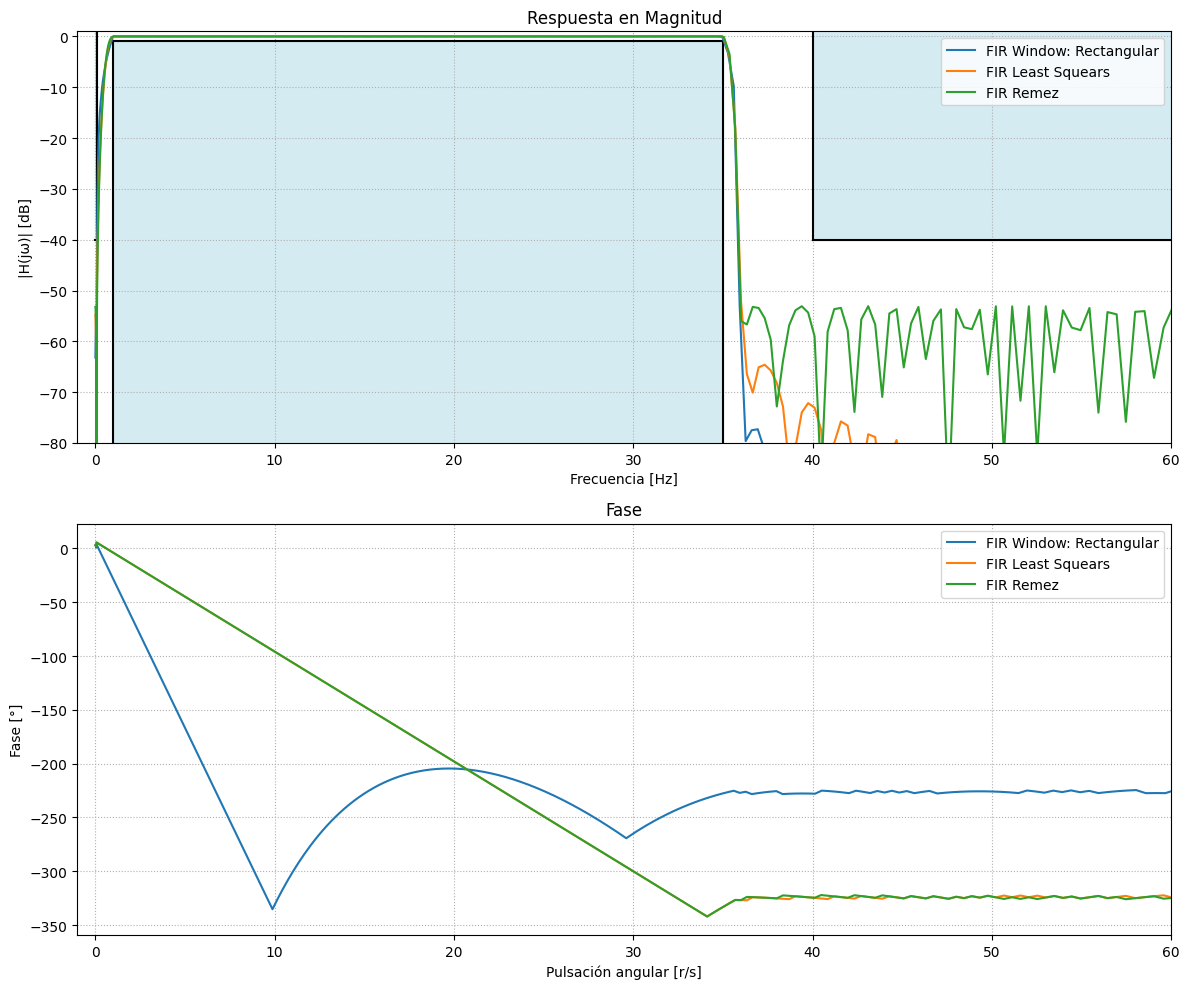

In [14]:
plt.figure(figsize=(12,10))
# Magnitud
plt.subplot(2,1,1)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w_win, 20*np.log10(np.abs(h_win)), label = 'FIR Window: Rectangular')
plt.plot(w_ls, 20*np.log10(np.abs(h_ls)), label = 'FIR Least Squears')
plt.plot(w_remez, 20*np.log10(np.abs(h_remez)), label = 'FIR Remez')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-80,1)
plt.xlim(-1,60)
plt.grid(True, which='both', ls=':')
plt.legend()
# Fase
plt.subplot(2,1,2)
plt.plot(w_win, phase_win, label = 'FIR Window: Rectangular')
plt.plot(w_ls, phase_ls, label = 'FIR Least Squears')
plt.plot(w_remez, phase_remez, label = 'FIR Remez')
plt.title('Fase')
plt.xlabel('Pulsación angular [r/s]')
plt.ylabel('Fase [°]')
plt.xlim(-1,60)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.tight_layout()
plt.show()


A simple vista se puede observar que efectivamente que los filtros cuentan con fase lineal en banda de paso. La diferencia de pendiente entre las mismas se relaciona directamente con la cantidad de coeficientes utilizados para el diseño. En cuanto al módulo, se observa que el comportamiento se asemeja a la plantilla. Se observa que cumplen sin conflictos en la segunda transición debido a la predistorción de la plantilla, pero no hay seguridad en cuanto a los vértices de la plantilla.

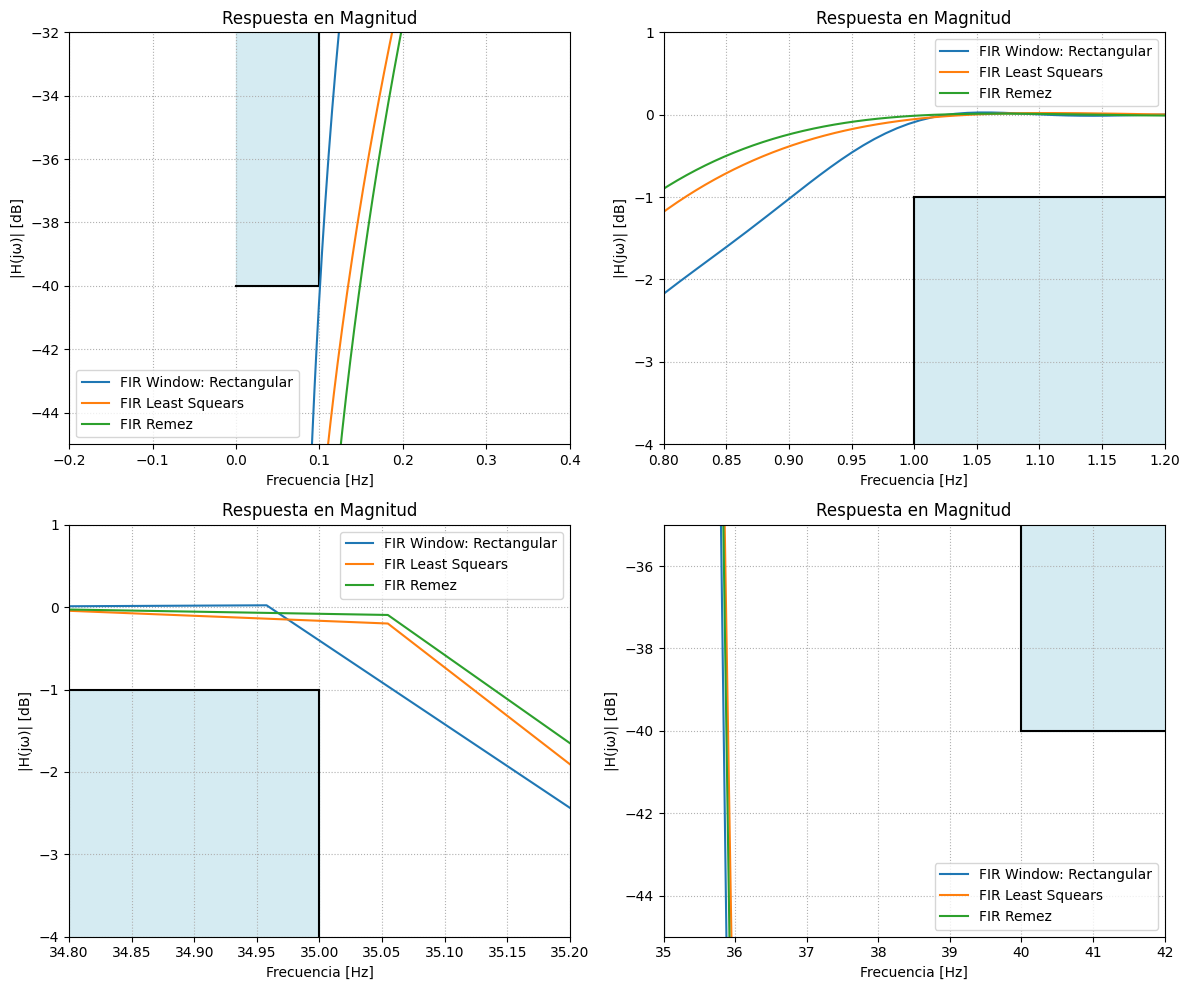

In [15]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w_win, 20*np.log10(np.abs(h_win)), label = 'FIR Window: Rectangular')
plt.plot(w_ls, 20*np.log10(np.abs(h_ls)), label = 'FIR Least Squears')
plt.plot(w_remez, 20*np.log10(np.abs(h_remez)), label = 'FIR Remez')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-45,-32)
plt.xlim(-0.2,0.4)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,2)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w_win, 20*np.log10(np.abs(h_win)), label = 'FIR Window: Rectangular')
plt.plot(w_ls, 20*np.log10(np.abs(h_ls)), label = 'FIR Least Squears')
plt.plot(w_remez, 20*np.log10(np.abs(h_remez)), label = 'FIR Remez')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-4,1)
plt.xlim(0.8,1.2)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,3)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w_win, 20*np.log10(np.abs(h_win)), label = 'FIR Window: Rectangular')
plt.plot(w_ls, 20*np.log10(np.abs(h_ls)), label = 'FIR Least Squears')
plt.plot(w_remez, 20*np.log10(np.abs(h_remez)), label = 'FIR Remez')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-4,1)
plt.xlim(34.8,35.2)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.subplot(2,2,4)
plantilla(ws = ws, wp = wp, fs = fs ,ripp = ripple, att = atenuacion)
plt.plot(w_win, 20*np.log10(np.abs(h_win)), label = 'FIR Window: Rectangular')
plt.plot(w_ls, 20*np.log10(np.abs(h_ls)), label = 'FIR Least Squears')
plt.plot(w_remez, 20*np.log10(np.abs(h_remez)), label = 'FIR Remez')
plt.title('Respuesta en Magnitud')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim(-45,-35)
plt.xlim(35,42)
plt.grid(True, which='both', ls=':')
plt.legend()

plt.tight_layout()
plt.show()

A partir de estos acercamientos, se puede concluir que los filtros si cumplen de forma satisfactoria la plantilla en todos sus vértices. Es importante observar que una gran desventaja del método de ventanas es que requiere de un orden muy alto para que cumpla con la plantilla a diferencia de los otros métodos. Un orden mayor implica mayor costo computacional y mayor retardo.

Al confirmar que los filtros funcionan correctamente, se procede por el filtrado de la señal. En este caso, no se realiza el filtrado bidireccional, ya que no presenta distorsión de fase. Para la aplicación del filtro se utilizó la función *lfilter*. Es importante para llevar a cabo la visualización sumar el retardo a la respuesta filtrada.

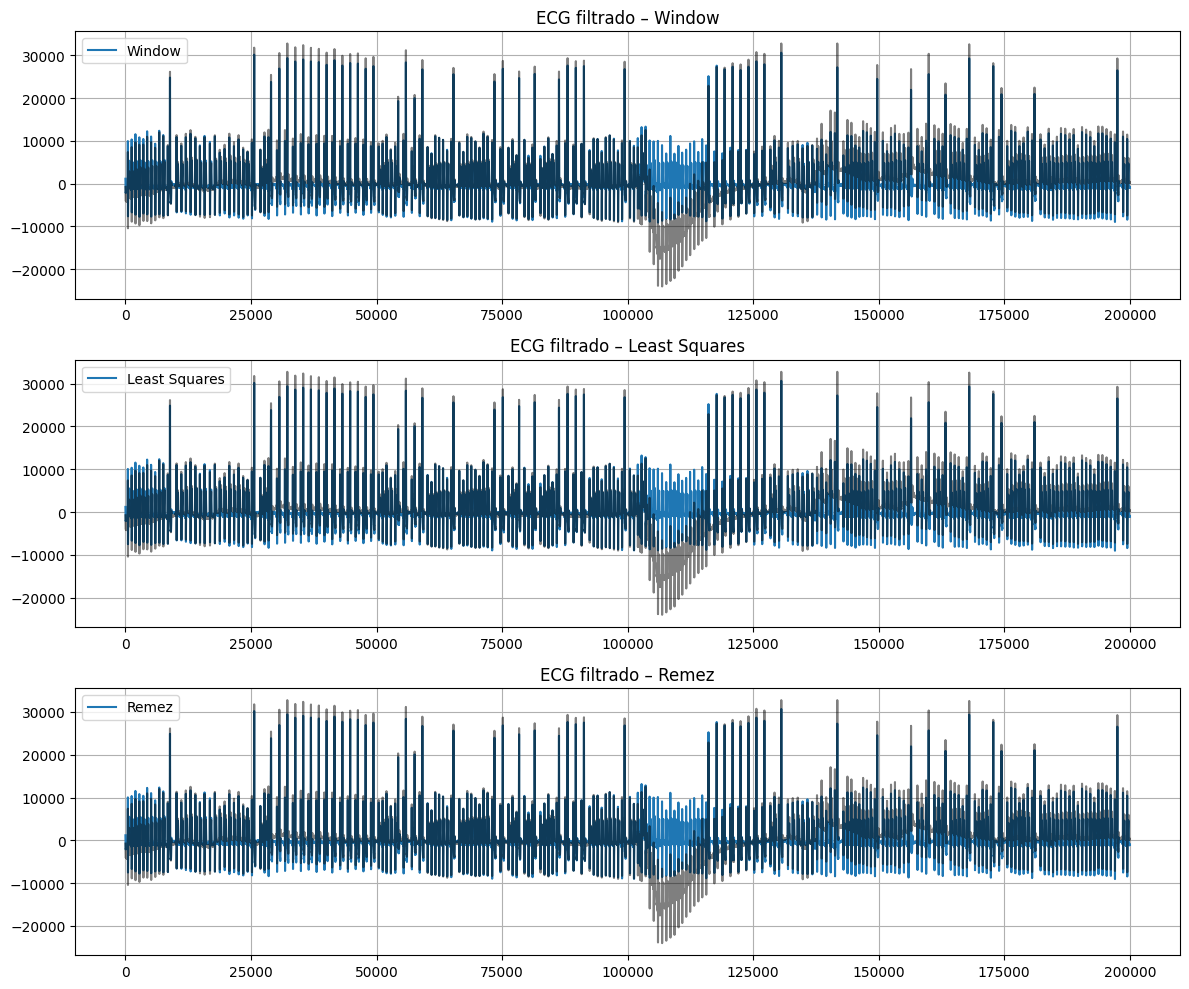

In [16]:
ecg_filt_win = signal.lfilter(b = fir_win, a = 1, x = ecg_one_lead)
ecg_filt_ls = signal.lfilter(b = fir_ls, a = 1, x = ecg_one_lead)
ecg_filt_remez = signal.lfilter(b = fir_remez, a = 1, x = ecg_one_lead)

# VISUALIZACIÓN GRAL
plt.figure(figsize=(12,10))

# Window
plt.subplot(3,1,1)
plt.plot(ecg_filt_win[retardo_win:200000+retardo_win], label='Window')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Window')
plt.legend()
plt.grid(True)

# Least Squares
plt.subplot(3,1,2)
plt.plot(ecg_filt_ls[retardo_ls:200000+retardo_ls], label='Least Squares')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Least Squares')
plt.legend()
plt.grid(True)

# Remez
plt.subplot(3,1,3)
plt.plot(ecg_filt_remez[retardo_remez:200000+retardo_ls], label='Remez')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Remez')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

En un panorama general, se observa que los filtros funcionan correctamente. A continuación, se lleva a cabo un análisis más profundo del filtrado en secciones del ECG, donde se presenta ruido en mayor y menor medida.

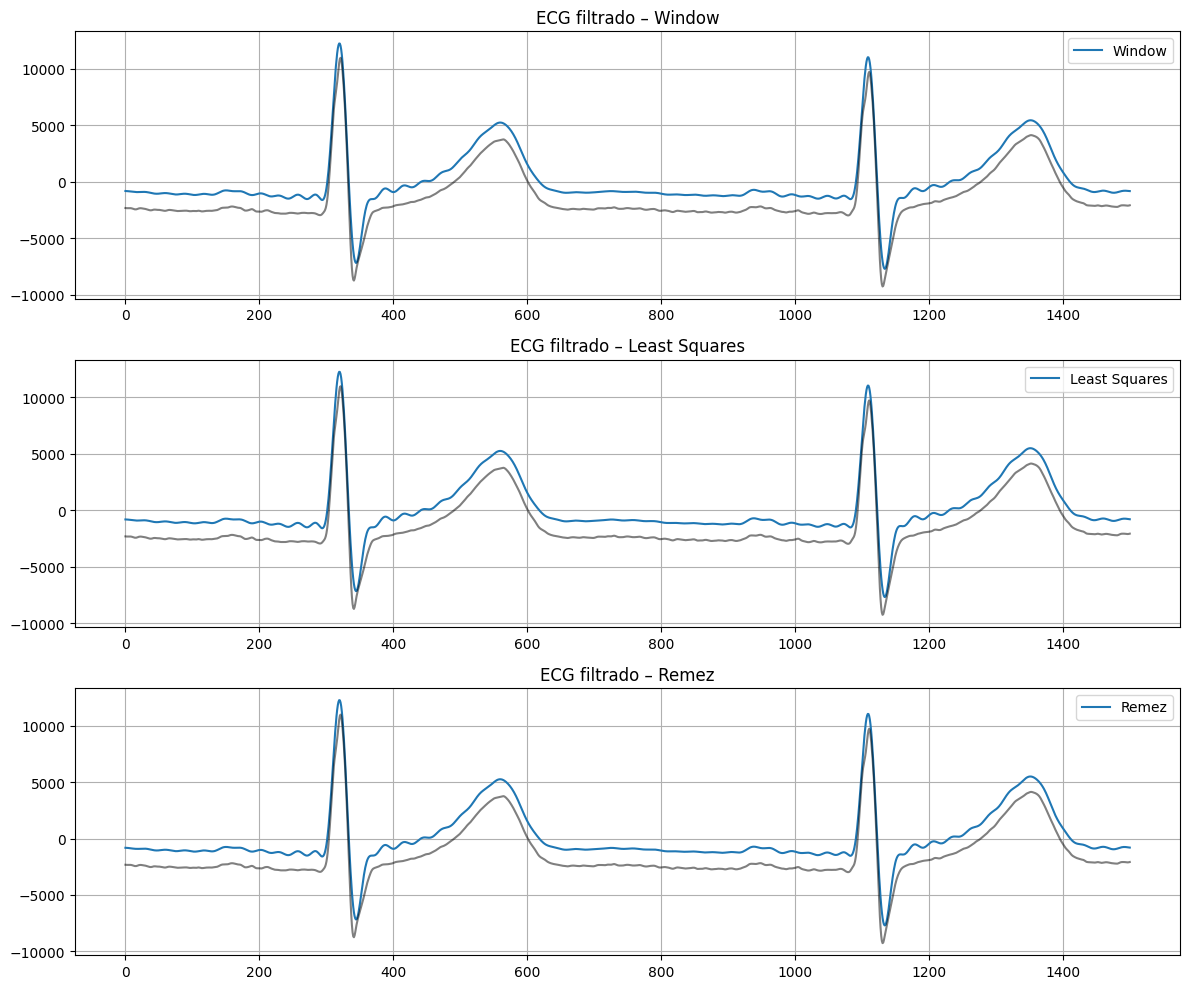

In [17]:
###### SIN RUIDO #######
plt.figure(figsize=(12,10))

# Window
plt.subplot(3,1,1)
plt.plot(ecg_filt_win[4000+retardo_win:5500+retardo_win], label='Window')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Window')
plt.legend()
plt.grid(True)

# LS
plt.subplot(3,1,2)
plt.plot(ecg_filt_ls[4000+retardo_ls:5500+retardo_ls], label='Least Squares')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Least Squares')
plt.legend()
plt.grid(True)

# Remez
plt.subplot(3,1,3)
plt.plot(ecg_filt_remez[4000+retardo_remez:5500+retardo_remez], label='Remez')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Remez')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

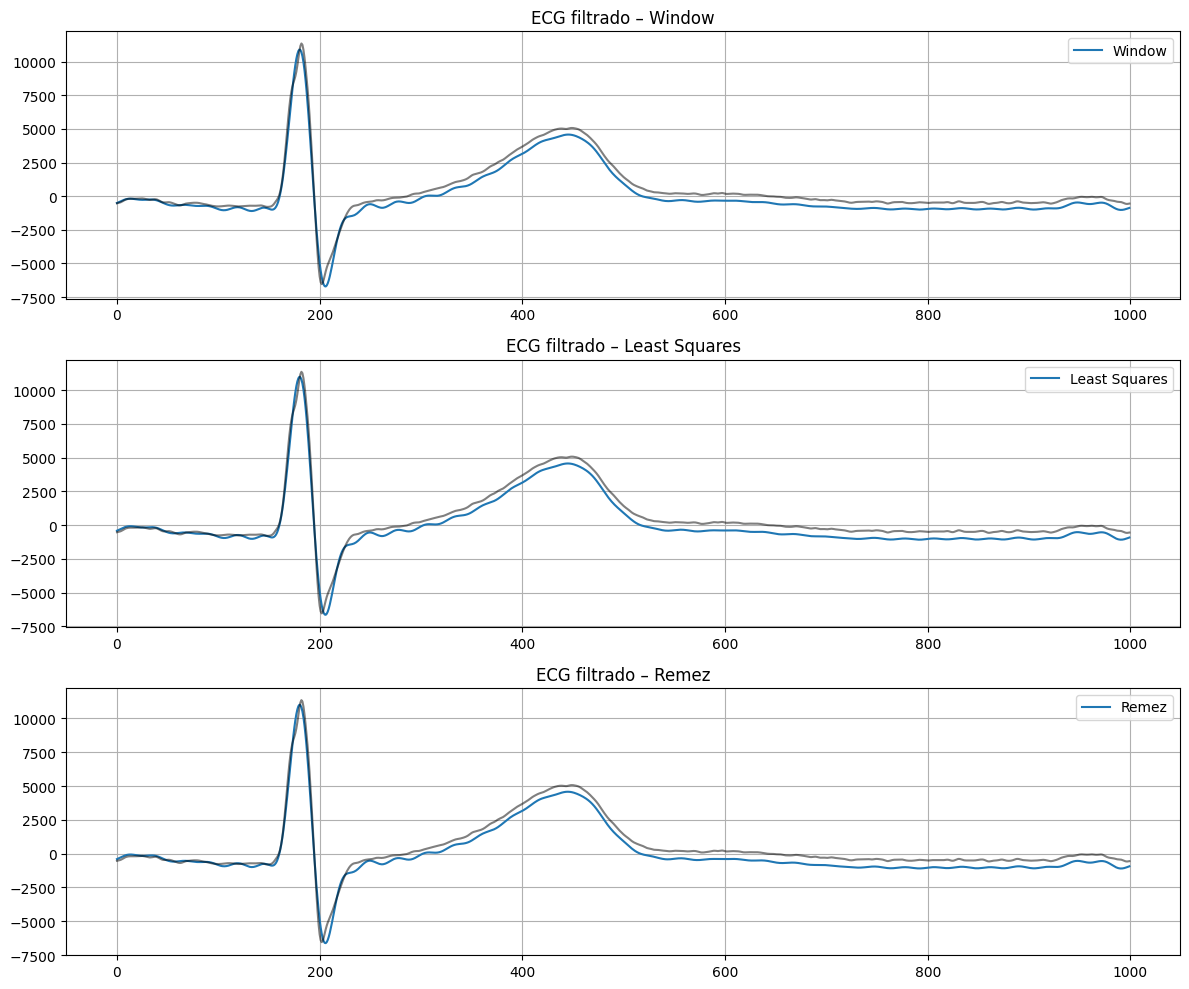

In [18]:
plt.figure(figsize=(12,10))

# Window
plt.subplot(3,1,1)
plt.plot(ecg_filt_win[10000+retardo_win:11000+retardo_win], label='Window')
plt.plot(ecg_one_lead[10000:11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Window')
plt.legend()
plt.grid(True)

# LS
plt.subplot(3,1,2)
plt.plot(ecg_filt_ls[10000+retardo_ls: 11000+retardo_ls], label='Least Squares')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Least Squares')
plt.legend()
plt.grid(True)

# Remez
plt.subplot(3,1,3)
plt.plot(ecg_filt_remez[10000+retardo_remez : 11000+retardo_remez], label='Remez')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Remez')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Al realizar el filtrado, se puede observar que los resultados son similares sobre las secciones que no presentan mucho ruido. En los intervalos cercanos al complejo QRS, se observan oscilaciones que no se presentan en la señal original. Este es un efecto de la respuesta al impulso del filtro. El complejo QRS presenta variaciones muy abruptas respecto del resto de la señal, de manera similar a una entrada tipo delta. Por este motivo, parte de la forma de la respuesta al impulso se replica alrededor del pico del QRS. Estas oscilaciones van disminuyendo progresivamente a medida que se alejan del punto de mayor cambio.

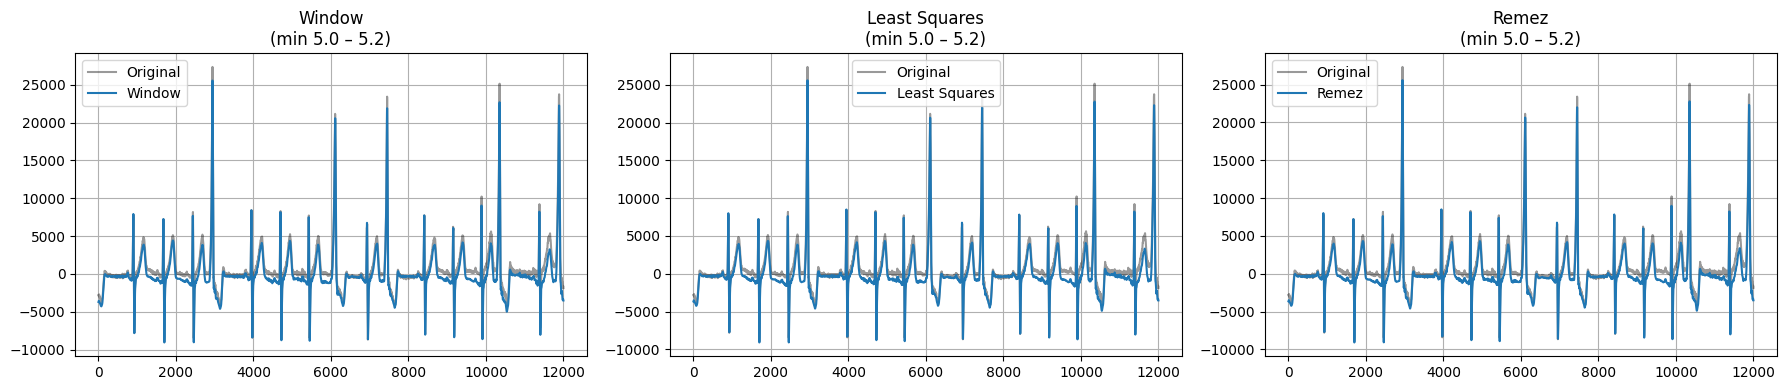

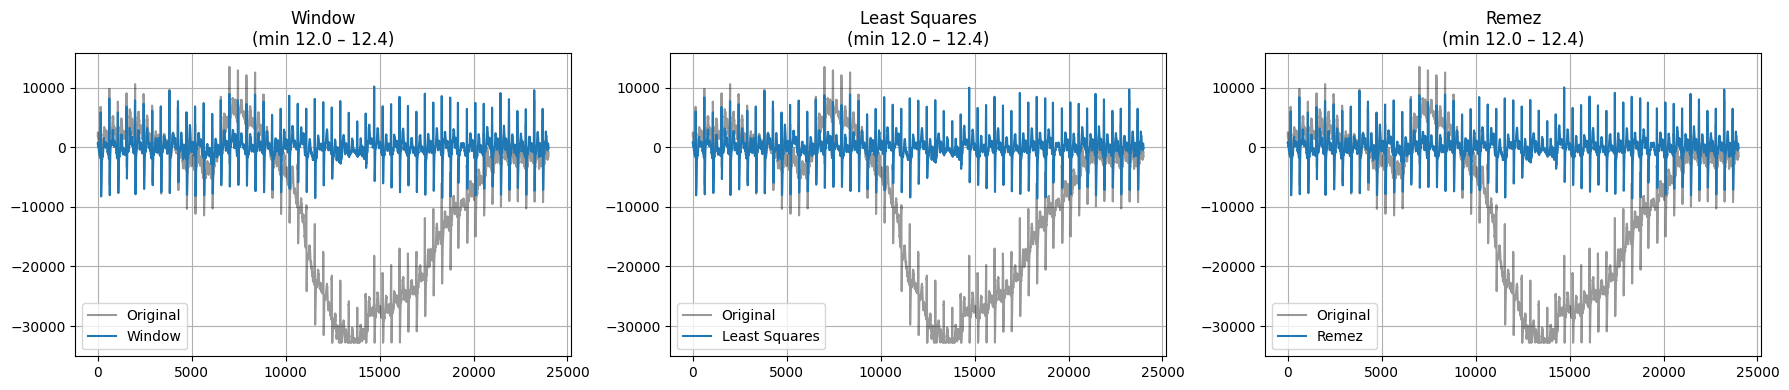

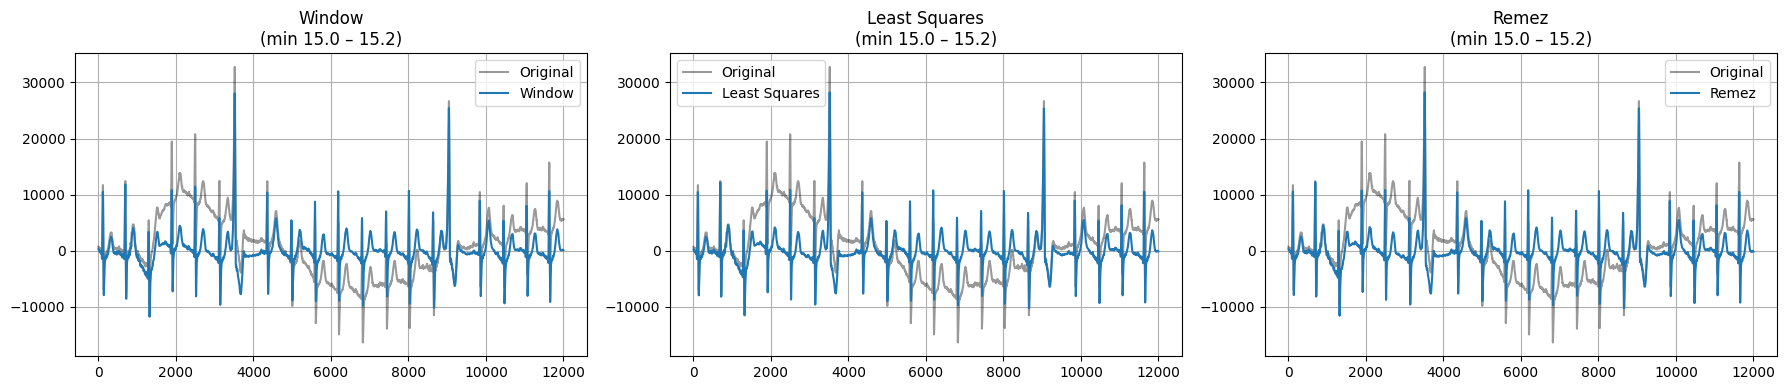

In [19]:
##### CON RUIDO ######
regs_interes = (
    np.array([5, 5.2])  * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

regs_interes = [(int(a), int(b)) for a, b in regs_interes]

filtros = [
    (ecg_filt_win, "Window", retardo_win),
    (ecg_filt_ls,  "Least Squares", retardo_ls),
    (ecg_filt_remez, "Remez", retardo_remez),
]

for (i0, i1) in regs_interes:
    
    plt.figure(figsize=(18,4))

    for j, (filt, nombre, retardo) in enumerate(filtros, start=1):

        plt.subplot(1, 3, j)
        plt.plot(ecg_one_lead[i0:i1], color='k', alpha=0.4, label="Original")
        plt.plot(filt[i0+retardo:i1+retardo], label=nombre)
        plt.title(f"{nombre}\n(min {i0/(fs*60):.1f} – {i1/(fs*60):.1f})")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

En caso de las secciones con mucho ruido, se observa que el rendimiento en general es bueno. En caso de la segunda sección presentada, se puede observar que la señal se cortó debido a una limitación de la forma en la cual se obtuvieron los datos, lo que implica una pérdida de información que no se puede resolver mediante el filtrado. 

## **Conclusiones**

Se concluye que los filtros propuestos, tanto IIR como FIR, lograron cumplir con las exigencias impuestas por la plantilla de diseño propuesta. Sin embargo, los primeros lograron este objetivo con mayor holgura que los IIR.  

Gracias a la implementación de Secciones Bicuadráticas y el filtrado bidireccional, se logó implementar filtros IIR cuyas desventajas fueran disminuidas; se evitó utilizar filtros de orden muy alto que pudieran tener errores computacionales y se obtuvo un filtrado de fase nula que logra evitar las distorsiones de fase características de estos sistemas. 


Se obtuvo una señal filtrada que conservó la morfología de la señal ECG original, lográndose observar claramente sus complejos constitutivos, y se logró mitigar el efecto del movimiento de línea de base, así como el efecto del ruido de alta frecuencia gracias a la atenuación mínima impuesta para la banda de stop de los filtros. 

## **Autoevaluación**
**Indicar una opción**:
*Resolví la tarea sin dudas*

**Responder**:

*¿Qué aprendiste al hacer esta tarea? ¿Qué te quedó claro? ¿Qué te sigue costando?*
Aprendimos sobre el diseño de filtros FIR e IIR. Logramos comprender cómo las modificaciones sobre los parámetros afectan el rendimiento de los filtros. Además, logramos distinguir las ventajas y desventajas que los distintos tipos de filtro presentan.

**Indicar si se utilizó IA**:
Se utilizó la IA para terminar de comprender conceptos teóricos.